In [66]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from model import TDRLSGalerkinSARIMA
import time

In [67]:
np.random.seed(123)
n = 300
t = np.arange(n)

# A: Noisy ARMA(2,1)
phi_true = [0.6, -0.3]
theta_true = [0.5]
eps = np.random.normal(scale=1.0, size=n)
y_a = np.zeros(n)
for i in range(2, n):
    y_a[i] = (phi_true[0] * y_a[i-1] + phi_true[1] * y_a[i-2] + theta_true[0] * eps[i-1] + eps[i])

# B: Seasonal sine + noise (period m=20)
y_b = np.sin(2 * np.pi * t / 20) + 0.5 * np.random.normal(size=n)

# C: Linear trend + AR(1)
eps_c = np.random.normal(scale=0.5, size=n)
y_c = np.zeros(n)
for i in range(1, n):
    y_c[i] = 0.01 * i + 0.8 * y_c[i-1] + eps_c[i]

# D: Nonlinear (Logistic map) + noise
r = 3.8
eps_d = np.random.normal(scale=0.02, size=n)
y_d = np.zeros(n)
y_d[0] = 0.4
for i in range(1, n):
    y_d[i] = r * y_d[i-1] * (1 - y_d[i-1]) + eps_d[i]

datasets = {
    'Noisy_ARMA': y_a,
    'Seasonal': y_b,
    'Trend_AR': y_c,
    'Nonlinear': y_d
}



In [68]:
window = 15
horizon = 250
num_runs = 1
p_values = [1]
q_values = [1]
P_values = [1]
Q_values = [1]
m_seasonal = 5
orders = [(p, q, P, Q) for p in p_values for q in q_values for P in P_values for Q in Q_values]

In [69]:
def td_forecast_k_steps(model: TDRLSGalerkinSARIMA, y_hist: np.ndarray, steps: int) -> np.ndarray:
    y_hist_work = np.asarray(y_hist, dtype=float).copy()
    out = []
    for _ in range(steps):
        t_last = len(y_hist_work) - 1
        phi_raw = model._build_phi(y_hist_work, t_last + 1)   # uses predicted history
        psi_raw = model._build_psi()                          # keeps past eps history frozen
        phi = model._scale_phi(phi_raw)
        psi = model._scale_psi(psi_raw)
        yhat = float(phi @ model.beta) + float(psi @ model.alpha)
        if not np.isfinite(yhat):
            yhat = y_hist_work[-1]
        out.append(yhat)
        y_hist_work = np.append(y_hist_work, yhat)
    return np.array(out, dtype=float)


In [70]:
import time

# keep your existing forecast_steps as-is (assumes it's already defined above)
all_results = []
first_run_preds = {}

for run in range(1, num_runs + 1):
    runs_left = num_runs - run
    print(f"\n=== Run {run}/{num_runs}  (runs left after this: {runs_left}) ===")

    for name, series in datasets.items():
        m = m_seasonal

        for p, q, P, Q in tqdm(orders, desc=f"Param combos for {name}", total=len(orders), leave=False):
            y_true = series[window:window + horizon]
            preds_td = []
            iter_times = []  # per-iteration wall-clock

            combo_start = time.perf_counter()

            for i in range(window, window + horizon):
                t0 = time.perf_counter()

                train = series[:i]
                model_td = TDRLSGalerkinSARIMA(
                    order=(p, 0, q),
                    seasonal_order=(P, 0, Q, m),
                    basis_functions="quadratic",   # same basis selection style as TI
                    rho=0.9999,
                    lambda_beta=1e-1,
                    lambda_alpha=1e-1,
                    standardize=False
                )
                model_td.fit(train)

                pred_vec = td_forecast_k_steps(model_td, train, steps=forecast_steps)
                preds_td.append(pred_vec)

                iter_times.append(time.perf_counter() - t0)

            combo_sec = time.perf_counter() - combo_start

            preds_td = np.array(preds_td)                 # shape: (horizon, steps)
            last_step_preds = preds_td[:, -1] if preds_td.ndim > 1 else preds_td

            if run == 1:
                first_run_preds[(name, p, q, P, Q)] = last_step_preds

            mask = ~np.isnan(last_step_preds)
            mae = mean_absolute_error(y_true[mask], last_step_preds[mask]) if mask.any() else np.nan
            rmse = np.sqrt(mean_squared_error(y_true[mask], last_step_preds[mask])) if mask.any() else np.nan

            # timing stats for this combo
            mean_iter_ms = float(np.mean(iter_times)) if len(iter_times) else np.nan
            median_iter_ms = float(np.median(iter_times)) if len(iter_times) else np.nan
            max_iter_ms = float(np.max(iter_times)) if len(iter_times) else np.nan
            throughput_iters_per_sec = (len(iter_times) / combo_sec) if combo_sec > 0 else np.nan

            all_results.append([
                name, p, q, P, Q, run, 'TD-Galerkin-SARIMA',
                mae, rmse,
                mean_iter_ms, median_iter_ms, max_iter_ms,
                combo_sec, len(iter_times), throughput_iters_per_sec
            ])

# Aggregate and print (timing included)
df = pd.DataFrame(
    all_results,
    columns=[
        'Dataset', 'p', 'q', 'P', 'Q', 'Run', 'Alg',
        'MAE', 'RMSE',
        'mean_iter_ms', 'median_iter_ms', 'max_iter_ms',
        'combo_sec', 'num_iters', 'throughput_iters_per_sec'
    ]
)
agg = df.groupby(['Dataset', 'p', 'q', 'P', 'Q', 'Alg'], as_index=False).mean(numeric_only=True)

print("\nAveraged over {} runs (including timing):\n".format(num_runs))
print(agg.to_markdown(index=False))


=== Run 1/1  (runs left after this: 0) ===



Averaged over 1 runs (including timing):

| Dataset    |   p |   q |   P |   Q | Alg                |   Run |      MAE |      RMSE |   mean_iter_ms |   median_iter_ms |   max_iter_ms |   combo_sec |   num_iters |   throughput_iters_per_sec |
|:-----------|----:|----:|----:|----:|:-------------------|------:|---------:|----------:|---------------:|-----------------:|--------------:|------------:|------------:|---------------------------:|
| Noisy_ARMA |   1 |   1 |   1 |   1 | TD-Galerkin-SARIMA |     1 | 1.09345  | 2.32808   |     0.00366341 |       0.00361719 |    0.00729021 |    0.915912 |         250 |                    272.952 |
| Nonlinear  |   1 |   1 |   1 |   1 | TD-Galerkin-SARIMA |     1 | 0.071943 | 0.0951078 |     0.00365939 |       0.00365273 |    0.00698283 |    0.914908 |         250 |                    273.251 |
| Seasonal   |   1 |   1 |   1 |   1 | TD-Galerkin-SARIMA |     1 | 0.536572 | 0.659673  |     0.00371011 |       0.00370435 |    0.00712238 |    0.927597 | 

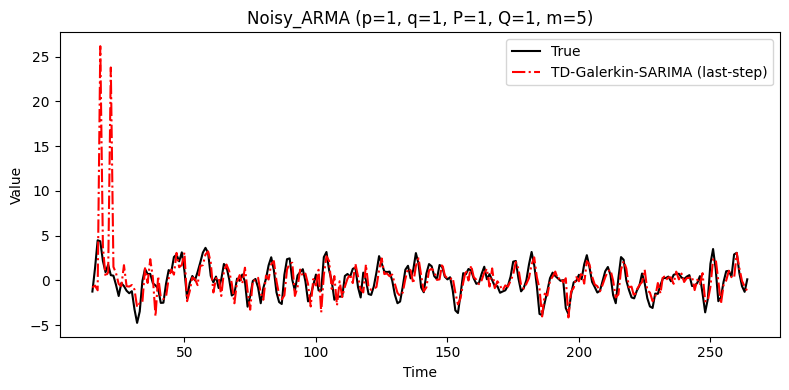

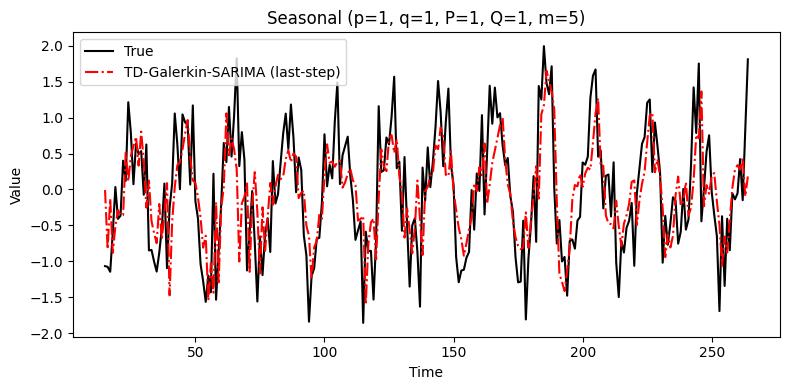

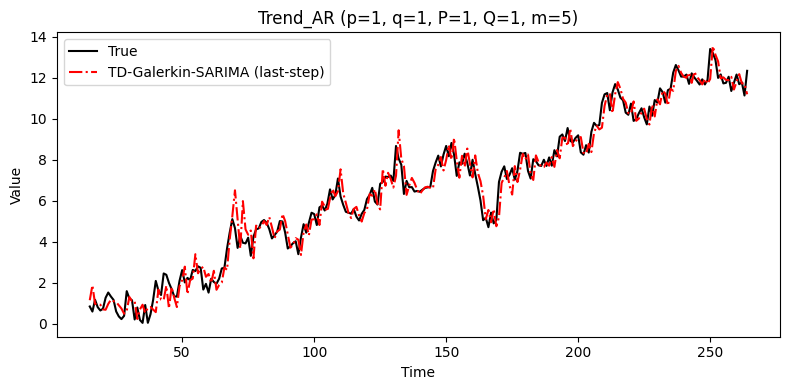

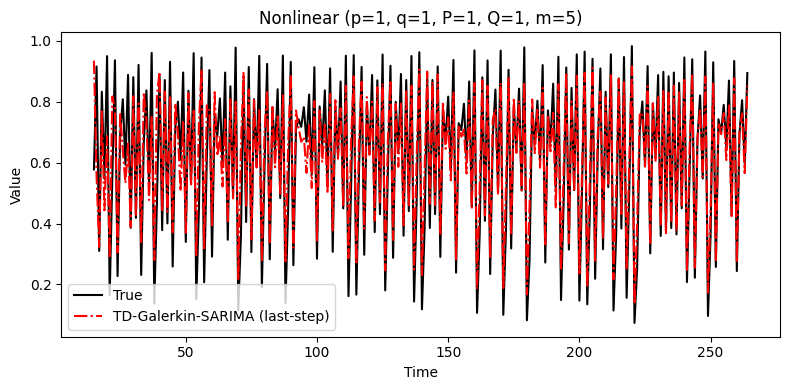

In [71]:
# results table


# ----- plots (same style; plot the saved last-step TD forecasts) -----
for name, series in datasets.items():
    for p, q, P, Q in orders:
        y_true = series[window:window + horizon]
        sg = first_run_preds[(name, p, q, P, Q)]

        plt.figure(figsize=(8, 4))
        plt.plot(range(window, window + horizon), y_true, 'k-', label='True')
        plt.plot(range(window, window + horizon), sg, 'r-.', label='TD-Galerkin-SARIMA (last-step)')
        plt.title(f"{name} (p={p}, q={q}, P={P}, Q={Q}, m={m_seasonal})")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.tight_layout()
        plt.show()